# Machine Leanring in Spark (Local computer)

## This notebook is desinged to work on your local computer. 
## Note: Install pyspark package via Anaconda before running this code.


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [2]:
# Check python version on your local pc. Spark runs on Python 2.7+/3.4+.
import sys
sys.version

'3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]'

In [3]:
# Spark version
print(spark.version)

3.1.2


## Exploring The Data

**The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.\
\
Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.\
\
Output variable: deposit**

### 1-Read Data

In [4]:
df_raw = spark.read.csv('bank.csv', header = True, inferSchema = True)
df_raw.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### 2-Explore Data

**2A. Let's use Pandas DataFrame for data exploration becuase it is prettier than Spark DataFrame.show()**

In [11]:
import pandas as pd
pd.DataFrame(df_raw.take(5), columns=df_raw.columns)
#pd.DataFrame(df_raw.take(5), columns=df_raw.columns).transpose()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


**2B. Check if the classes are balanced. --> Our Classes are perfect balanced**

In [12]:
df_raw.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


**2C. Check summary statistics for numeric features.**

In [13]:
df_raw.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [14]:
numeric_features = [t[0] for t in df_raw.dtypes if t[1] == 'int']
df_raw.select(numeric_features).describe().toPandas()
# df_raw.select(numeric_features).describe().toPandas().transpose()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


**2D. Check correlations between independent variables.**

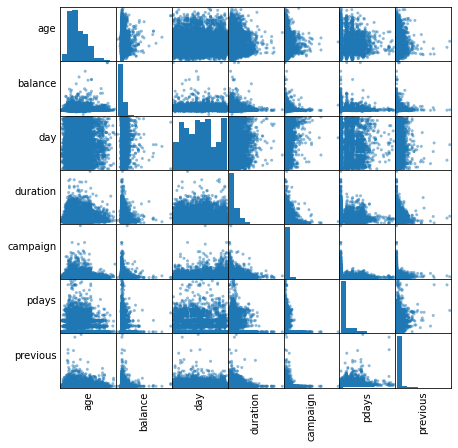

In [15]:
from pandas.plotting import scatter_matrix
numeric_data = df_raw.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(7, 7));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

**Key Observation: It's obvious that there aren't highly correlated independent variables. Therefore, we will keep all of them for the model.**

**However, day and month columns are not really useful, we will remove these two columns.**

In [16]:
# Select all but day and month
# Option-1
cols = list(set(df_raw.columns) - {'day', 'month'})
df = df_raw.select(cols)

# Option-2
# df = df_raw.select('age', 'job', 'marital', 'education', \
#                'default', 'balance', 'housing', 'loan', \
#                'contact', 'duration', 'campaign', 'pdays', \
#                'previous', 'poutcome', 'deposit')

# Option-3
#df = df_raw.drop('day', 'month') --> this will modify the original DF (df_raw)

In [17]:
df.printSchema()

root
 |-- default: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- education: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- previous: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- loan: string (nullable = true)
 |-- job: string (nullable = true)
 |-- campaign: integer (nullable = true)



In [18]:
len(df.columns)

15

In [19]:
len(df_raw.columns)

17

In [20]:
df_raw.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### 3-Preparing Data for Machine Learning

**Category Indexing, One-Hot Encoding and VectorAssembler - a feature transformer that merges multiple columns into a vector column.**

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [22]:
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # Numerical Features
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

**The above code are taken from databricks' official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices.\
\
Next, we use the VectorAssembler to combine all the feature columns into a single vector column.**

### 4-Create Data Analytics Pipeline

**We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.**

**Note: Execute the following code only once. Multiple executation may result in an error. If the error occure (see at the end of the error list: "Output column label already exists."), go back to the block that has this line, df = df_raw.select(cols), and execute every step after this point.**  

In [23]:
cols = df.columns

In [24]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- default: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- education: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- previous: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- loan: string (nullable = true)
 |-- job: string (nullable = true)
 |-- campaign: integer (nullable = true)



In [26]:
pd.DataFrame(df.take(5), columns=df.columns)
# pd.DataFrame(df.take(5), columns=df.columns).transpose()

,label,features,default,marital,deposit,education,contact,poutcome,previous,balance,housing,age,duration,pdays,loan,job,campaign
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,married,yes,secondary,unknown,unknown,0,2343,yes,59,1042,-1,no,admin.,1
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,married,yes,secondary,unknown,unknown,0,45,no,56,1467,-1,no,admin.,1
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,married,yes,secondary,unknown,unknown,0,1270,yes,41,1389,-1,no,technician,1
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",no,married,yes,secondary,unknown,unknown,0,2476,yes,55,579,-1,no,services,1
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,married,yes,tertiary,unknown,unknown,0,184,no,54,673,-1,no,admin.,2


In [ ]:
#pd.DataFrame(df.select("features").take(5))

In [ ]:
#df.select("features")

In [27]:
v = df.select("features")
v.head(5)

[Row(features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 59.0, 25: 2343.0, 26: 1042.0, 27: 1.0, 28: -1.0})),
 Row(features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 56.0, 25: 45.0, 26: 1467.0, 27: 1.0, 28: -1.0})),
 Row(features=SparseVector(30, {2: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 41.0, 25: 1270.0, 26: 1389.0, 27: 1.0, 28: -1.0})),
 Row(features=SparseVector(30, {4: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 55.0, 25: 2476.0, 26: 579.0, 27: 1.0, 28: -1.0})),
 Row(features=SparseVector(30, {3: 1.0, 11: 1.0, 14: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 54.0, 25: 184.0, 26: 673.0, 27: 2.0, 28: -1.0}))]

In [31]:
pd.DataFrame(df_raw.take(5), columns=df_raw.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


**As you can see, we now have features column and label column\
\
Randomly split data into train and test sets. set seed for reproducibility**

In [30]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


### 5-ML Modeling 

### 5A. Model-1: Logistic Regression Model

In [32]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

**We can obtain the coefficients by using LogisticRegressionModel's attributes.**

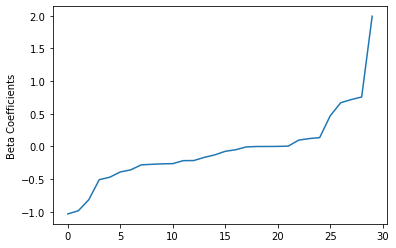

In [33]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

**Obtain the receiver-operating characteristic and areaUnderROC**

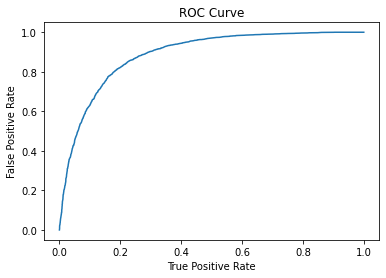

Training set areaUnderROC: 0.8865551189326405


In [34]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

**Precision and Recall**

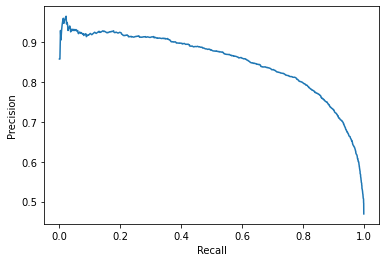

In [35]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**Set the model threshold to maximize F-Measure**

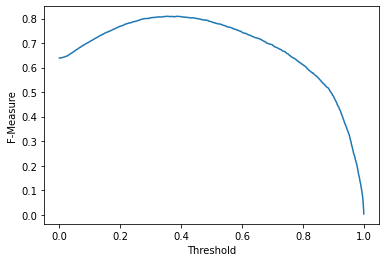

In [37]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Make predictions on the test set

In [38]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93500470498079...|       0.0|[0.87380233100701...|
| 49|management|  0.0|[2.04809361205496...|       0.0|[0.88575484704982...|
| 52|management|  0.0|[-0.7002122133357...|       1.0|[0.33176517908283...|
| 53|management|  0.0|[1.03431610227357...|       0.0|[0.73775180622517...|
| 58|management|  0.0|[2.74273671692568...|       0.0|[0.93950183380104...|
| 32|management|  0.0|[1.25033004378244...|       0.0|[0.77735698810451...|
| 57|management|  0.0|[1.19540519867323...|       0.0|[0.76770638557283...|
| 52|management|  0.0|[3.26456982709641...|       0.0|[0.96319314409492...|
| 46|management|  0.0|[2.15036209979036...|       0.0|[0.89570260888977...|
| 31|management|  0.0|[1.47751802200862...|       0.0|[0.81419739986183...|
+---+-------

### Evaluate our Logistic Regression model

In [39]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8837112925002687


In [40]:
evaluator.getMetricName()

'areaUnderROC'

**Pretty good.**

### 5B. Model-2: Decision Tree Classifier

**Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.**

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

**Evaluate our Decision Tree model**

In [42]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


**One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods.**

### 5C. Model-3: Random Forest Classifier

In [43]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[13.9468224592172...|       0.0|[0.69734112296086...|
| 49|management|  0.0|[13.5287283139181...|       0.0|[0.67643641569590...|
| 52|management|  0.0|[6.97853139599958...|       1.0|[0.34892656979997...|
| 53|management|  0.0|[12.1918234793660...|       0.0|[0.60959117396830...|
| 58|management|  0.0|[14.6503386871538...|       0.0|[0.73251693435769...|
| 32|management|  0.0|[14.3048370302146...|       0.0|[0.71524185151073...|
| 57|management|  0.0|[14.0858898055805...|       0.0|[0.70429449027902...|
| 52|management|  0.0|[16.6045418306303...|       0.0|[0.83022709153151...|
| 46|management|  0.0|[16.7735597112831...|       0.0|[0.83867798556415...|
| 31|management|  0.0|[12.7560815374048...|       0.0|[0.63780407687024...|
+---+-------

In [44]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8808187553267224


### 5D. Model-4: Gradient-boosted Tree Classifier

In [45]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

**Evaluate our Gradient-Boosted Tree Classifier.**

In [46]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8935091626908479


In [48]:
# Stop SparkSession
spark.stop()